# Basic use of MIDS

In [3]:
import sys
import os

import numpy as np
from typing import List, Optional, Dict
import pandas as pd
import matplotlib.pyplot as plt
from data_structures.rules.multi_target_class_association_rule import MCAR

from mdrsl.toy_data.titanic import prepare_data_titanic

from mdrsl.rule_generation.association_rule_mining.mlext_impl.mlext_interaction import mine_MCARs_mlext

from mdrsl.rule_models.multi_target_rule_set_clf_utils.rule_combining_strategy import RuleCombiningStrategy
from mdrsl.rule_models.mids.model_fitting.mids_with_value_reuse import MIDSValueReuse
from mdrsl.rule_models.mids.model_fitting.mids_fitting_meta_data import MIDSOptimizationMetaData
from mdrsl.rule_models.mids.mids_classifier import MIDSClassifier

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'mlxtend'

## Loading the Titanic toy dataset

In [4]:
from mdrsl.project_info import project_dir
print(project_dir)
data_dir = os.path.join(project_dir, 'data/external')

/home/joschout/Documents/Repos/MULES/Multi-Directional_Rule_Set_Learning


In [5]:
df_train: pd.DataFrame
df_test: pd.DataFrame

df_train, df_test, dataset_name = prepare_data_titanic(data_dir, prop=0.25)
df_train.head()

,Passenger_Cat,Age_Cat,Gender,Survived
0,3rd_class,adult,male,0
1,3rd_class,adult,female,0
2,crew,adult,male,0
3,crew,adult,male,0
4,2nd_class,adult,male,0


In [6]:
cols: np.ndarray = df_train.columns.values
cols

array(['Passenger_Cat', 'Age_Cat', 'Gender', 'Survived'], dtype=object)

## Mining multi-target association rules

In [11]:
min_support = 0.01
min_confidence = 0.5
rule_cutoff = 150

cars: List[MCAR]
time_info: Dict[str, float]

cars, time_info = mine_MCARs_mlext(df_train, min_support=min_support, min_confidence=min_confidence)
if len(cars) > rule_cutoff:
    cars = cars[:rule_cutoff]

In [12]:
from mdrsl.data_structures.rules.pretty_printing import mids_mcar_to_pretty_string
for rule in cars:
    print(mids_mcar_to_pretty_string(rule))

Gender=male -> Age_Cat=adult
Age_Cat=adult -> Gender=male
Survived=0 -> Age_Cat=adult
Age_Cat=adult -> Survived=0
Gender=male -> Survived=0
Survived=0 -> Gender=male
Gender=male, Survived=0 -> Age_Cat=adult
Age_Cat=adult, Gender=male -> Survived=0
Age_Cat=adult, Survived=0 -> Gender=male
Gender=male -> Age_Cat=adult, Survived=0
Survived=0 -> Age_Cat=adult, Gender=male
Age_Cat=adult -> Gender=male, Survived=0
Passenger_Cat=3rd_class -> Age_Cat=adult
Passenger_Cat=3rd_class -> Survived=0
Passenger_Cat=3rd_class -> Gender=male
Passenger_Cat=3rd_class, Survived=0 -> Age_Cat=adult
Age_Cat=adult, Passenger_Cat=3rd_class -> Survived=0
Passenger_Cat=3rd_class -> Age_Cat=adult, Survived=0
Gender=male, Passenger_Cat=3rd_class -> Age_Cat=adult
Age_Cat=adult, Passenger_Cat=3rd_class -> Gender=male
Passenger_Cat=3rd_class -> Age_Cat=adult, Gender=male
Gender=male, Passenger_Cat=3rd_class -> Survived=0
Passenger_Cat=3rd_class, Survived=0 -> Gender=male
Passenger_Cat=3rd_class -> Gender=male, Survive

## Fitting a MIDS model

In [ ]:
from mdrsl.rule_models.mids.objective_function.mids_objective_function_abstract import AbstractMIDSObjectiveFunction
from mdrsl.rule_models.mids.model_fitting.mids_without_value_reuse import MIDS
from mdrsl.utils.value_collection import ValueCollector

ValueCollector.collect_values = True

use_targets_from_rule_set = False
debug=False
AbstractMIDSObjectiveFunction.should_cache_f2_f3 = False


In [14]:
algorithm="RDGS"
from submodmax.value_reuse.randomized_double_greedy_search import RandomizedDoubleGreedySearch
RandomizedDoubleGreedySearch.N_TRIES = 1

mids = MIDSValueReuse()
mids.fit(df_train,
         use_targets_from_rule_set=use_targets_from_rule_set,
         class_association_rules=cars, algorithm=algorithm, debug=debug)

/home/joschout/Projects/MULES/MULES-Project/src/datasets/dataset_utils.py:16: UserWarning: Removed QuantitiveDataFrame type check, might need to be included again
  warnings.warn("Removed QuantitiveDataFrame type check, might need to be included again")
/home/joschout/Projects/MULES/MULES-Project/src/datasets/dataset_utils.py:34: UserWarning: All columns of a dataframe should be string types.
The following columns are not stringly typed:
	Survived: int64 Maybe you did not discretize all numerical attributes?
CONVERTED THESE COLUMNS TO STRING!
  " Maybe you did not discretize all numerical attributes?\n"
/home/joschout/Repos/SubmodularMaximization/submodmax/value_reuse/abstract_double_greedy_search.py:135: UserWarning: remove equality check
  warnings.warn("remove equality check")
/home/joschout/Projects/MULES/MULES-Project/src/mids/default_classes.py:24: UserWarning: multiple modes found for some attributes in the training data; 
  Passenger_Cat Age_Cat Gender Survived
0          crew 

overlap cache prepared


## Inspecting the fitted model

In [ ]:
tree_mids_rules = mids.classifier.rules
max_len: int = max([len(mids_mcar_to_pretty_string(mids_rule.car)) for mids_rule in tree_mids_rules])

mids_rule_strs = []
for mids_rule in tree_mids_rules:
    mids_rule_strs.append(mids_mcar_to_pretty_string(mids_rule.car).ljust(
            max_len) + "\t" + f"s: {mids_rule.car.support:0.3f}, c: {mids_rule.car.confidence:0.3f}")

mids_rule_strs.sort()
for s in mids_rule_strs:
    print(s)
print("Defaults", mids.classifier.default_predictions)
print("---")

In [35]:
print(mids.objective_function.stat_collector)

type              f0          f1          f2          f3          f4          f5          f6    f_total
--------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ---------
count     102         102         102         102         102         102         102         102
sum        65.34       71.2067    100.624     101.932      52.5        99.3004     59.1847    550.087
min         0           0.166667    0.94857     0.99848     0           0.939576    0           4.28555
avg         0.640588    0.698105    0.986506    0.999332    0.514706    0.973533    0.580242    5.39301
max         1           1           1           1           0.5625      1           0.669758    5.91276
last_val    0.86        0.886667    0.997656    0.999673    0.5625      0.984572    0.621688    5.91276


In [36]:

import seaborn as sns
data:Optional[pd.DataFrame] = mids.objective_function.stat_collector.values_to_pandas_dataframe()

In [37]:
data.groupby(['type']).describe()


value                                                              \
         count      mean       std       min       25%       50%       75%   
type                                                                         
f0       102.0  0.640588  0.304338  0.000000  0.405000  0.840000  0.880000   
f1       102.0  0.698105  0.254184  0.166667  0.496667  0.866667  0.893333   
f2       102.0  0.986506  0.016092  0.948570  0.977242  0.996481  0.997623   
f3       102.0  0.999332  0.000573  0.998480  0.998781  0.999628  0.999918   
f4       102.0  0.514706  0.100346  0.000000  0.468750  0.562500  0.562500   
f5       102.0  0.973533  0.016052  0.939576  0.959985  0.982430  0.984992   
f6       102.0  0.580242  0.133098  0.000000  0.572199  0.628690  0.658403   
f_total  102.0  5.393012  0.509640  4.285551  5.022993  5.649516  5.867485   

                   
              max  
type               
f0       1.000000  
f1       1.000000  
f2       1.000000  
f3       1.000000  
f4       0.562500  
f5       1.000000  
f6       0.669758  
f_total  5.912756

In [38]:
nb_of_evaluations = mids.objective_function.stat_collector.value_collectors['f1'].count
data.groupby(['type']).describe()

value                                                              \
         count      mean       std       min       25%       50%       75%   
type                                                                         
f0       102.0  0.640588  0.304338  0.000000  0.405000  0.840000  0.880000   
f1       102.0  0.698105  0.254184  0.166667  0.496667  0.866667  0.893333   
f2       102.0  0.986506  0.016092  0.948570  0.977242  0.996481  0.997623   
f3       102.0  0.999332  0.000573  0.998480  0.998781  0.999628  0.999918   
f4       102.0  0.514706  0.100346  0.000000  0.468750  0.562500  0.562500   
f5       102.0  0.973533  0.016052  0.939576  0.959985  0.982430  0.984992   
f6       102.0  0.580242  0.133098  0.000000  0.572199  0.628690  0.658403   
f_total  102.0  5.393012  0.509640  4.285551  5.022993  5.649516  5.867485   

                   
              max  
type               
f0       1.000000  
f1       1.000000  
f2       1.000000  
f3       1.000000  
f4       0.562500  
f5       1.000000  
f6       0.669758  
f_total  5.912756

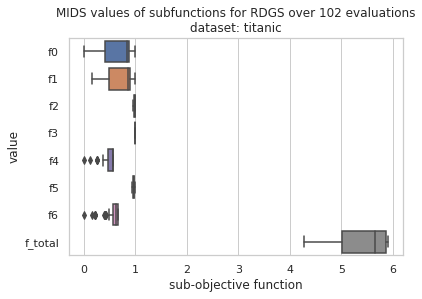

In [39]:
sns.set(style="whitegrid")
ax= sns.boxplot(y='type', x='value', data=data)


ax.set_xlabel('sub-objective function')
ax.set_ylabel('value')
ax.set_title('MIDS values of subfunctions for '+ algorithm+ ' over ' + str(nb_of_evaluations) + ' evaluations\n'
             'dataset: ' + dataset_name
             )


from datetime import datetime
current_date = datetime.today().strftime('%Y-%m-%d')

image_dir = os.path.join(project_dir, 'images')
file_name = current_date + "_" + dataset_name + "_mids_"+ algorithm + "_function_values" + ".png"
abs_file_name = os.path.join(image_dir, file_name)

plt.savefig(abs_file_name)


In [40]:
data2:Optional[pd.DataFrame] = mids.objective_function.stat_collector.values_to_pandas_dataframe2()
data2.head()

,call_index,type,value
0,0,f0,1.00
1,1,f0,0.00
2,2,f0,0.98
3,3,f0,0.02
4,4,f0,0.96


Text(0.5, 1.0, 'Evolution of f_total over time')

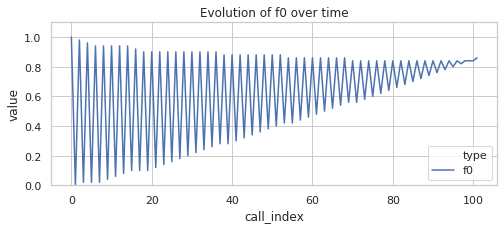

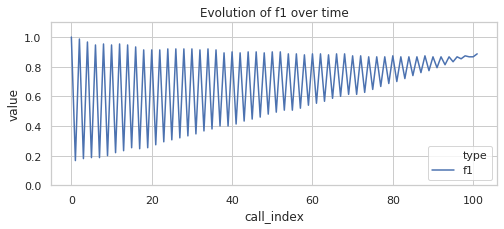

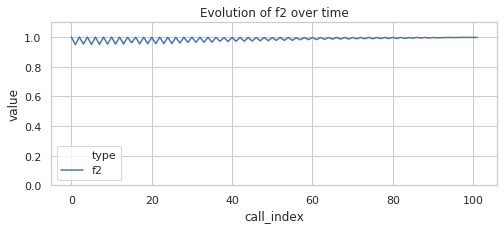

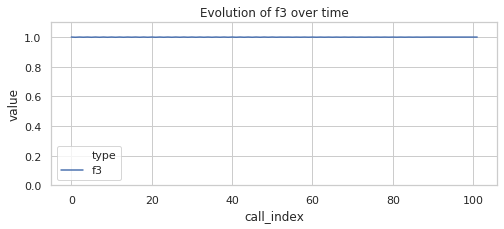

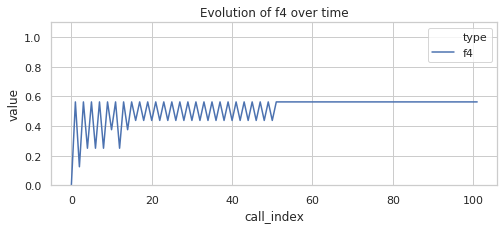

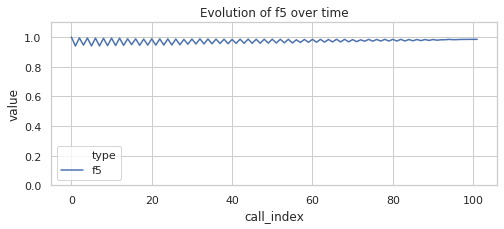

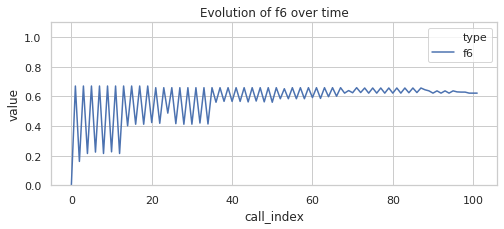

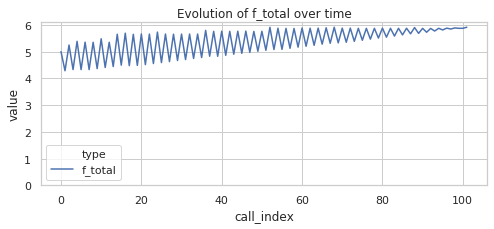

In [41]:

for f_type in ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']:
    width = 8
    height = 3
    figsize = (width, height)
    fig, axes = plt.subplots(figsize=figsize)
    ax2 = sns.lineplot(x='call_index',
               y='value',
               data=data2[data2['type'] == f_type],
               hue='type'
               )
    ax2.set_ylim(0, 1.1)
    ax2.set_title(f"Evolution of {f_type} over time")

# --
fig, axes = plt.subplots(figsize=figsize)
ax2 = sns.lineplot(x='call_index',
           y='value',
           data=data2[data2['type'] == 'f_total'],
           hue='type'
           )
ax2.set_ylim(0, 6.1)
ax2.set_title(f"Evolution of f_total over time")

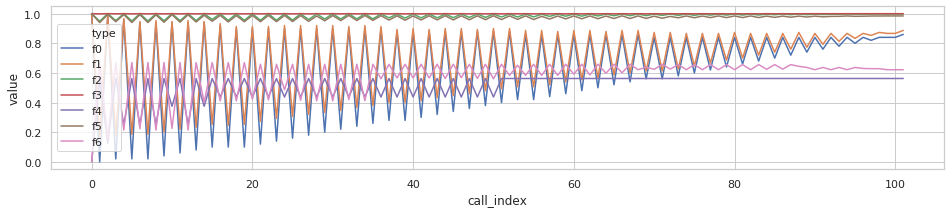

In [42]:
width = 16
height = 3
figsize = (width, height)
fig, axes = plt.subplots(figsize=figsize)
ax3 = sns.lineplot(x='call_index',
           y='value',
           data=data2[data2['type'].isin(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6'])],
           hue='type'
           )


In [43]:
AbstractMIDSObjectiveFunction.should_cache_f2_f3 = True
mids2 = MIDS()
mids2.fit(df_train,
          use_targets_from_rule_set=use_targets_from_rule_set,
          class_association_rules=cars, algorithm=algorithm, debug=debug)

/home/joschout/Projects/MULES/MULES-Project/src/datasets/dataset_utils.py:16: UserWarning: Removed QuantitiveDataFrame type check, might need to be included again
  warnings.warn("Removed QuantitiveDataFrame type check, might need to be included again")
/home/joschout/Repos/SubmodularMaximization/submodmax/abstract_double_greedy_search.py:84: UserWarning: remove equality check
  warnings.warn("remove equality check")
/home/joschout/Projects/MULES/MULES-Project/src/mids/default_classes.py:103: UserWarning: multiple modes found for some attributes in the training data; 
  Passenger_Cat Age_Cat Gender Survived
0          crew   adult   male        0
  warnings.warn("multiple modes found for some attributes in the training data; \n" + str(df_modes))


overlap cache prepared
INITIALIZE f2 f3 cache
max nb of integers necessary: 4900
rough estimate nb of bytes necessary: 117600
FINISHED INITIALIZATION f2 f3 cache


In [44]:
print(mids2.objective_function.stat_collector)
print()
print(mids.objective_function.stat_collector)

type               f0           f1           f2           f3           f4           f5           f6     f_total
--------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ----------
count     1031         1031         1031         1031         1031         1031         1031         1031
sum        643.48       712.953     1017.92      1030.56       542.938     1005.75       591.97      5545.57
min          0            0.166667     0.94857      0.99848      0            0.939576     0            4.28555
avg          0.624132     0.691516     0.987311     0.999575     0.526613     0.975513     0.574171     5.37883
max          1            1            1            1            0.5625       1            0.669758     5.92985
last_val     0.86         0.886667     0.999741     0.999872     0.5625       0.98916      0.631908     5.92985

type              f0          f1          f2          f3          f4          f5          f6    f_total
--------

In [45]:
classifier = mids.classifier
for mids_rule in classifier.rules:
    print(mids_mcar_to_pretty_string(mids_rule.car))
    

Age_Cat=adult -> Survived=0
Age_Cat=adult -> Gender=male, Survived=0
Passenger_Cat=1st_class -> Survived=1
Passenger_Cat=3rd_class, Survived=0 -> Age_Cat=adult
Gender=male -> Age_Cat=adult, Survived=0
Age_Cat=child -> Passenger_Cat=3rd_class
Gender=female -> Age_Cat=adult


In [46]:
print(str(mids.classifier))

MIDS classifier (7 rules)
	Rule combination stategy: RuleCombiningStrategy.WEIGHTED_VOTE
	Default value strategy: DefaultClassStrategy.MAJORITY_VALUE_OVER_WHOLE_TRAINING_SET
		Default predictions:{'Survived': '0', 'Age_Cat': 'adult', 'Passenger_Cat': 'crew', 'Gender': 'male'}



In [47]:
from interpretability.mids_interpretability_metrics import MIDSInterpretabilityStatisticsCalculator
from mids.mids_ruleset import MIDSRuleSet
metrics_calc = MIDSInterpretabilityStatisticsCalculator()
rule_set_stats = metrics_calc.calculate_ruleset_statistics(
    MIDSRuleSet(mids.classifier.rules), df_test, target_attributes=mids.classifier.target_attrs)
print(rule_set_stats)


Rule length stats: count=7, sum=17, min=2, average=2.4285714285714284, max=3
Fraction bodily overlap: 0.19036796536796535
Fraction uncovered examples: 0.0
Avg fraction predicted classes: 0.5625
Fraction predicted classs by target:
	{'Survived': 1.0, 'Age_Cat': 0.5, 'Passenger_Cat': 0.25, 'Gender': 0.5}



/home/joschout/Projects/MULES/MULES-Project/src/interpretability/mids_interpretability_metrics.py:89: UserWarning: FRACTION_OVERLAP IS CURRENTLY NOT RELATIVE TO A TARGET ATTRIBUTE. THIS MIGHT BE INCORRECT
  warnings.warn("FRACTION_OVERLAP IS CURRENTLY NOT RELATIVE TO A TARGET ATTRIBUTE. THIS MIGHT BE INCORRECT")
/home/joschout/Projects/MULES/MULES-Project/src/interpretability/mids_interpretability_metrics.py:261: UserWarning: Ugly conversion to string to deal with numerical attributes. Clean this up (look at Survived in Titanic).
  "Ugly conversion to string to deal with numerical attributes."


In [18]:
from sklearn.metrics import accuracy_score, f1_score
import functools
micro_avged_f1_score = functools.partial(f1_score, average='micro')

metric = micro_avged_f1_score
col_to_acc = {}
for target_attribute in df_test.columns:
    predicted_values = mids.predict(df_test, target_attribute)
    actual_values = df_test[target_attribute].values
    print("column:", target_attribute)
    score = metric(predicted_values, actual_values)
    print("\tscore:", score)
    print("---")
    col_to_acc[target_attribute] = score
    
print(col_to_acc)

/home/joschout/Projects/MULES/MULES-Project/src/datasets/dataset_utils.py:16: UserWarning: Removed QuantitiveDataFrame type check, might need to be included again
  warnings.warn("Removed QuantitiveDataFrame type check, might need to be included again")


column: Passenger_Cat
	score: 0.4318181818181818
---
column: Age_Cat
	score: 0.9500000000000001
---
column: Gender
	score: 0.8181818181818182
---
column: Survived
	score: 0.7522727272727272
---
{'Passenger_Cat': 0.4318181818181818, 'Age_Cat': 0.9500000000000001, 'Gender': 0.8181818181818182, 'Survived': 0.7522727272727272}


In [49]:
rule_combination_strategy = RuleCombiningStrategy.WEIGHTED_VOTE

weigted_vote_mids_clf = MIDSClassifier(rules=mids.classifier.rules,
                                       df_training_data=df_train,
                                       target_attributes=mids.classifier.target_attrs,
                                       optimization_meta_data=mids.classifier.optimization_meta_data,
                                       rule_combination_strategy=rule_combination_strategy)


col_to_acc2 = {}
for target_attribute in df_test.columns:
    predicted_values = mids.predict(df_test, target_attribute)
    actual_values = df_test[target_attribute].values
    print("column:", target_attribute)
    score = metric(predicted_values, actual_values)
    print("\tscore:", score)
    print("---")
    col_to_acc2[target_attribute] = score

column: Passenger_Cat
	score: 0.4409090909090909
---
column: Age_Cat
	score: 0.9613636363636363
---
column: Gender
	score: 0.7863636363636364
---
column: Survived
	score: 0.6681818181818182
---


In [50]:
mids_opt_meta_data: MIDSOptimizationMetaData = mids.classifier.optimization_meta_data